In [184]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [185]:
from augmentation import get_augmentations

class Args:
    aug = 'barlow'
    img_size = 224

barlow = get_augmentations(Args())


In [186]:
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

image_file_path = '/netscratch/saifullah/rvl-cdip-wo-tobacco3842/subset/form/correct/88025296.tif'
image = np.array(Image.open(image_file_path))
# plt.imshow(image, cmap='gray')
# plt.show()
# blurred = ocrodeg.binary_blur(image.astype(np.float32), 1.0, noise=0.01)
# # blotched = ocrodeg.random_blotches(image, 3e-4, 1e-4)
# plt.imshow(blurred, cmap='gray')
# plt.show()
image = torch.tensor(image)

In [187]:
from das.data.transforms.grayscale_to_rgb import GrayScaleToRGB
import random
from PIL import Image, ImageOps, ImageFilter
import ocrodeg

class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x


class Solarization(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            return ImageOps.solarize(img)
        else:
            return img




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


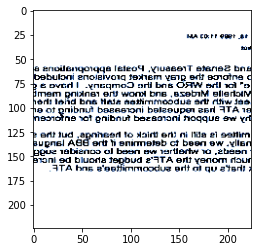

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


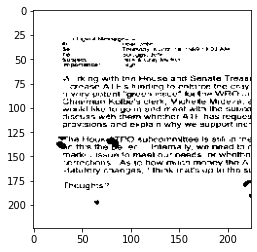

In [224]:
import torchvision
from torchvision.transforms import RandomResizedCrop
from torchvision.transforms import functional as F
from torchvision.transforms.functional import InterpolationMode, _interpolation_modes_from_int
import math

class RandomResizedCropCustom(RandomResizedCrop):
    @staticmethod
    def get_params(img, scale, ratio, region_mask):
        """Get parameters for ``crop`` for a random sized crop.

        Args:
            img (PIL Image or Tensor): Input image.
            scale (list): range of scale of the origin size cropped
            ratio (list): range of aspect ratio of the origin aspect ratio cropped

        Returns:
            tuple: params (i, j, h, w) to be passed to ``crop`` for a random
            sized crop.
        """
        width, height = F._get_image_size(img)
        area = height * width

        log_ratio = torch.log(torch.tensor(ratio))
        for _ in range(10):
            target_area = area * torch.empty(1).uniform_(scale[0], scale[1]).item()
            aspect_ratio = torch.exp(
                torch.empty(1).uniform_(log_ratio[0], log_ratio[1])
            ).item()

            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))

            if 0 < w <= width and 0 < h <= height:
                # mask = region_mask[h//2:height-h//2, w//2:width-w//2]
                pixel_list = region_mask.nonzero()
                p_idx = torch.randint(0, max(1, len(pixel_list)), size=(1, )).item()
                i = pixel_list[p_idx][0] - h // 2
                j = pixel_list[p_idx][1] - w // 2
                i = torch.clip(i, min=0, max=height - h)
                j = torch.clip(j, min=0, max=width - w)
                    
                return i, j, h, w

        # Fallback to central crop
        in_ratio = float(width) / float(height)
        if in_ratio < min(ratio):
            w = width
            h = int(round(w / min(ratio)))
        elif in_ratio > max(ratio):
            h = height
            w = int(round(h * max(ratio)))
        else:  # whole image
            w = width
            h = height
        i = (height - h) // 2
        j = (width - w) // 2
        return i, j, h, w

    def forward(self, img, pixel_list):
        """
        Args:
            img (PIL Image or Tensor): Image to be cropped and resized.

        Returns:
            PIL Image or Tensor: Randomly cropped and resized image.
        """
        i, j, h, w = self.get_params(img, self.scale, self.ratio, pixel_list)
        return F.resized_crop(img, i, j, h, w, self.size, self.interpolation)


def get_black_and_white_regions_mask(image_tensor):
    black_and_white_threshold = 0.5
    c, h, w = image_tensor.shape
    ky = 8
    kx = 8
    black_and_white_regions_fast = (image_tensor[0].unfold(
        0, ky, kx).unfold(1, ky, kx) < black_and_white_threshold).any(dim=2).any(dim=2)
    black_and_white_regions_fast = black_and_white_regions_fast.repeat_interleave(
        ky, dim=0).repeat_interleave(kx, dim=1)
    black_and_white_regions_fast = torchvision.transforms.functional.resize(
        black_and_white_regions_fast.unsqueeze(0), [h, w]).squeeze()
    return ((black_and_white_regions_fast).float())


class RandomResizedCropThreshold(object):
    def __init__(self, img_size):
        self.t = RandomResizedCropCustom((img_size,img_size), scale=(0.05, 0.15))
        # self.t = transforms.Resize((img_size, img_size))
        # self.grid_xy = 4

    def __call__(self, img):
        region = get_black_and_white_regions_mask(img)
        img = self.t(img, region)
        return img

        # c, h, w = img.shape
        # size_y = h // self.grid_xy # patch size
        # size_x = w // self.grid_xy  # patch stride
        # patches = img.unfold(1, size_y, size_y).unfold(2, size_x, size_x)
        # patches = patches.reshape(c, self.grid_xy * self.grid_xy, size_y, size_x).permute(1, 0, 2, 3)
        # valid_patches = []
        # for i in range(patches.shape[0]):
        #     if len(patches[i][patches[i] < 0.5]) > 0:
        #         valid_patches.append(self.t(patches[i]))
        # return torch.stack(valid_patches)


class Blotches(object):
    def __call__(self, img):
        if len(img.shape) != 2:
            img = img.squeeze()
        return torch.from_numpy(ocrodeg.random_blotches(np.array(img), 3e-4, 1e-4)).unsqueeze(0)

class BinaryBlur(object):
    def __call__(self, img):
        if len(img.shape) != 2:
            img = img.squeeze()
        return torch.from_numpy(ocrodeg.binary_blur(np.array(img), 0.5)).unsqueeze(0)


class DocumentAugmentations2(object):
    def __init__(self, img_size):
        self.aug1 = transforms.Compose([
            RandomResizedCropThreshold(img_size),
            transforms.RandomApply([BinaryBlur()], p=0.5),
            transforms.RandomHorizontalFlip(p=0.5),
            GrayScaleToRGB(),
            transforms.ToPILImage(),
            transforms.RandomApply(
                [transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)],
                p=0.8
            ),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([GaussianBlur([.1, .5])], p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.aug2 = transforms.Compose([
            RandomResizedCropThreshold(img_size),            
            transforms.RandomApply([Blotches()], p=0.2),
            transforms.RandomApply([BinaryBlur()], p=0.5),
            transforms.RandomHorizontalFlip(p=0.5),
            GrayScaleToRGB(),
            transforms.ToPILImage(),
            transforms.RandomApply(
                [transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)],
                p=0.8
            ),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([GaussianBlur([.1, .5])], p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __call__(self, image):
        crops = []
        crops.append(self.aug1(image))
        crops.append(self.aug2(image))
        return crops
        
doc_augs = DocumentAugmentations2(img_size=224)

# image_file_path = '/netscratch/saifullah/rvl-cdip-wo-tobacco3842/subset/form/correct/88025296.tif'
image_file_path = '/netscratch/saifullah/rvl-cdip-wo-tobacco3842/subset/email/correct/2064207242a.tif'
# image_file_path = '/netscratch/saifullah/rvl-cdip-wo-tobacco3842/subset/invoice/correct/00922031.tif'
for i in range(1):
    image = np.array(Image.open(image_file_path))   
    image = image / 255.
    image = torch.tensor(image)
    if len(image.shape) == 2:
        image = image.unsqueeze(0)
    images = doc_augs(image)
    for image in images:
        plt.imshow(image.permute(1, 2, 0))
        plt.show()